# Time series direct forecasting

## Alessia Cotroneo, Alessandro Del Vitto, Michele Di Sabato - 2nd Homework for the course Artificial Neural Networks and Deep Learning.

This notebook contains the implementation of the best Direct Forecasting model we used to solve the time series forecasting task. As explained in the report, we used bidirectional Long Short Term Memory layers as building blocks for the model.

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.6.2


In [2]:
dataset = pd.read_csv('../input/hm2-timeseries/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [3]:
# dataset.info()

In [4]:
# Useful functions

def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

    
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
    
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green') 
        # le linee verdi hanno dei segmenti che sono sovrascitti, poiché i samples in X_test sono sovrappost (visto che stride != window)
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [5]:
# inspect_dataframe(dataset, dataset.columns)

(64528, 7) (4000, 7)


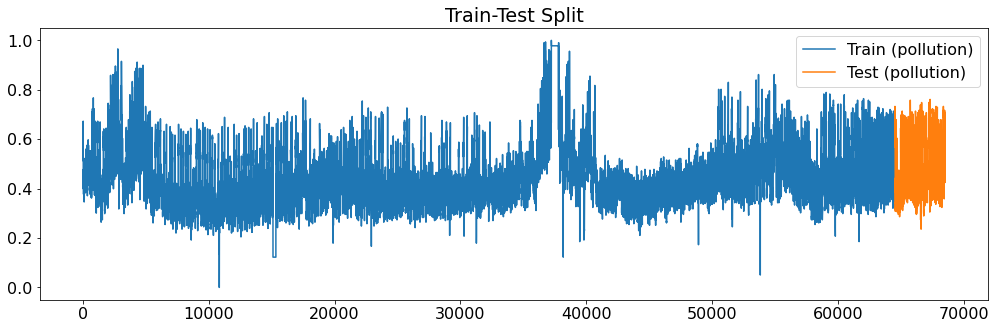

In [6]:
test_size = 4000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (pollution)')
plt.plot(X_test_raw.Sponginess, label='Test (pollution)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

### Window, Stride and Telescope

In [7]:
target_labels = dataset.columns
telescope = 864 # for the first phase of the challenge
window = 100
stride = 10

In [8]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 100, 7)

In [9]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6364, 100, 7), (6364, 864, 7), (304, 100, 7), (304, 864, 7))

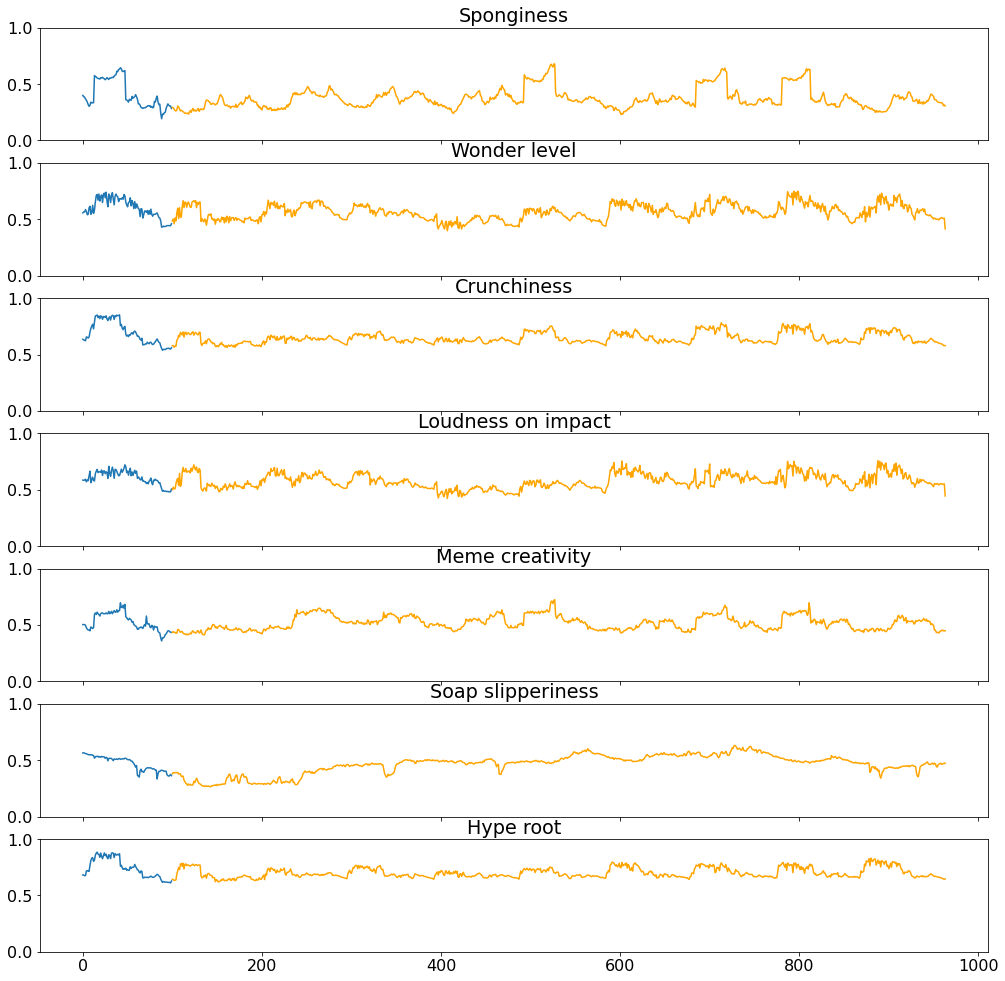

In [10]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [11]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

### Define the model

In [12]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm) 
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    
    convlstm = tfkl.Dropout(.4)(convlstm)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    # model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mse'])
    # model.compile(loss=tfk.losses.MeanAbsolutePercentageError(), optimizer=tfk.optimizers.Adam(), metrics=['mse'])
    model.compile(loss=tfk.losses.MeanAbsoluteError(), optimizer=tfk.optimizers.Adam(), metrics=['mse'])

    return model

2022-01-06 21:12:33.210294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 21:12:33.293514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 21:12:33.294300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 21:12:33.295493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 100, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          139264    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 256)          196864    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 256)           196864    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 256)           196864

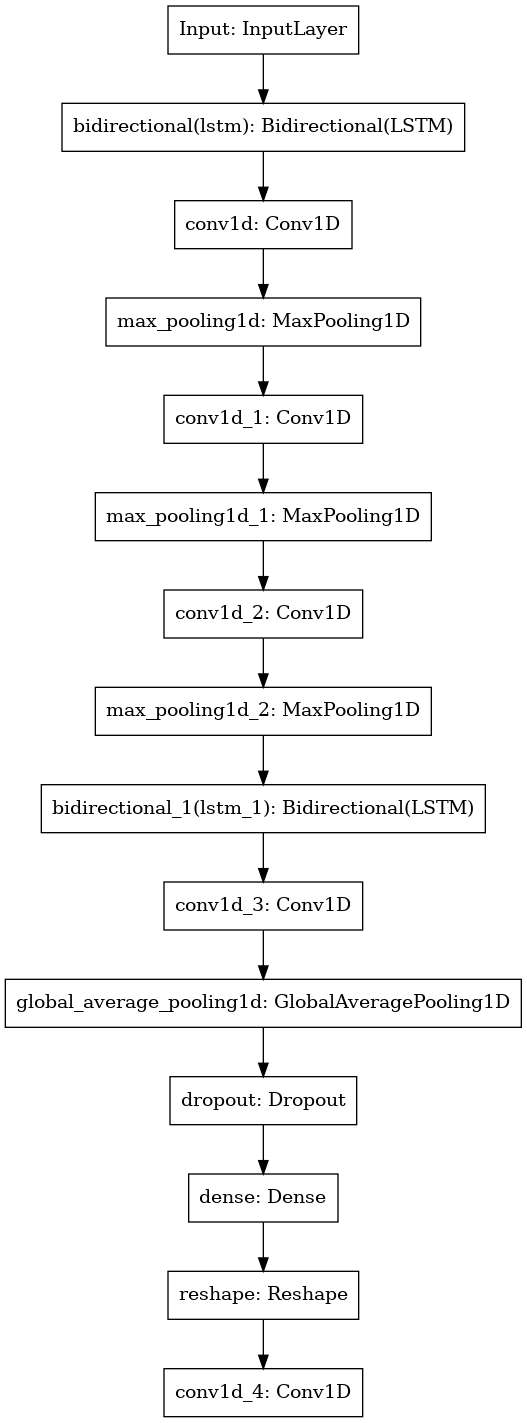

In [13]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-06 21:12:37.695622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-06 21:12:43.152582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 15s 44ms/step - loss: 0.2750 - mse: 0.1244 - val_loss: 0.2122 - val_mse: 0.0803
Epoch 2/200
90/90 [==============================] - 2s 25ms/step - loss: 0.1676 - mse: 0.0522 - val_loss: 0.1569 - val_mse: 0.0429
Epoch 3/200
90/90 [==============================] - 2s 25ms/step - loss: 0.1303 - mse: 0.0291 - val_loss: 0.1291 - val_mse: 0.0306
Epoch 4/200
90/90 [==============================] - 2s 25ms/step - loss: 0.1111 - mse: 0.0216 - val_loss: 0.1227 - val_mse: 0.0288
Epoch 5/200
90/90 [==============================] - 2s 28ms/step - loss: 0.1048 - mse: 0.0198 - val_loss: 0.1089 - val_mse: 0.0225
Epoch 6/200
90/90 [==============================] - 3s 28ms/step - loss: 0.0999 - mse: 0.0184 - val_loss: 0.1054 - val_mse: 0.0222
Epoch 7/200
90/90 [==============================] - 2s 25ms/step - loss: 0.0972 - mse: 0.0176 - val_loss: 0.1014 - val_mse: 0.0206
Epoch 8/200
90/90 [==============================] - 2s 26ms/step - loss: 0.0946 - mse:

In [15]:
model.save('DirectForecasting')
# model = tfk.models.load_model('DirectForecasting')

2022-01-06 21:16:12.580055: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


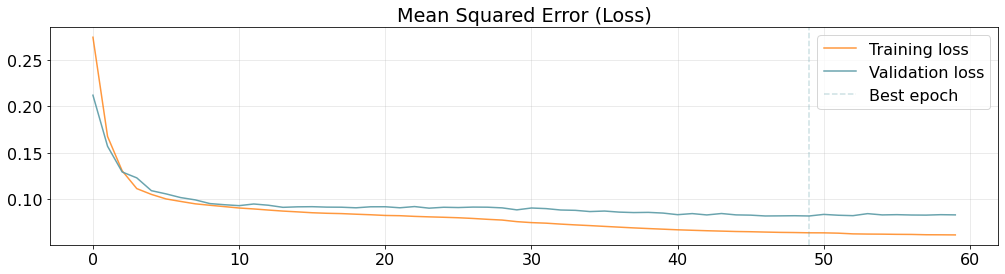

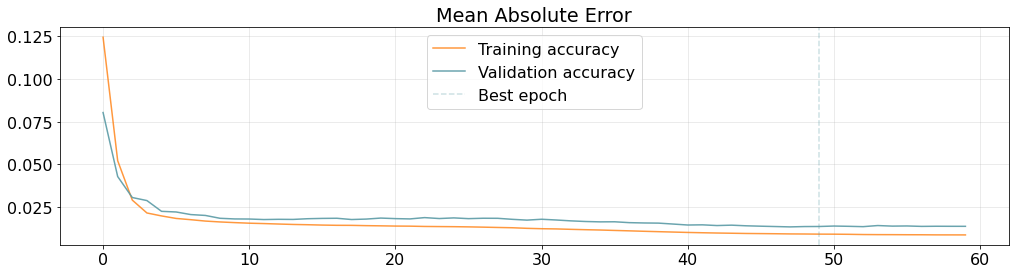

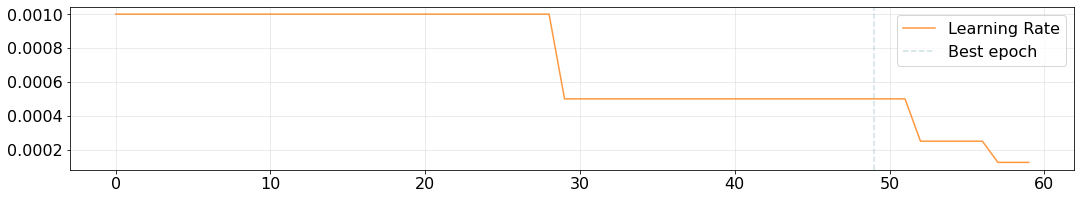

In [16]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Predict on the **test set**

In [17]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(304, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.014155389>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08958027>)

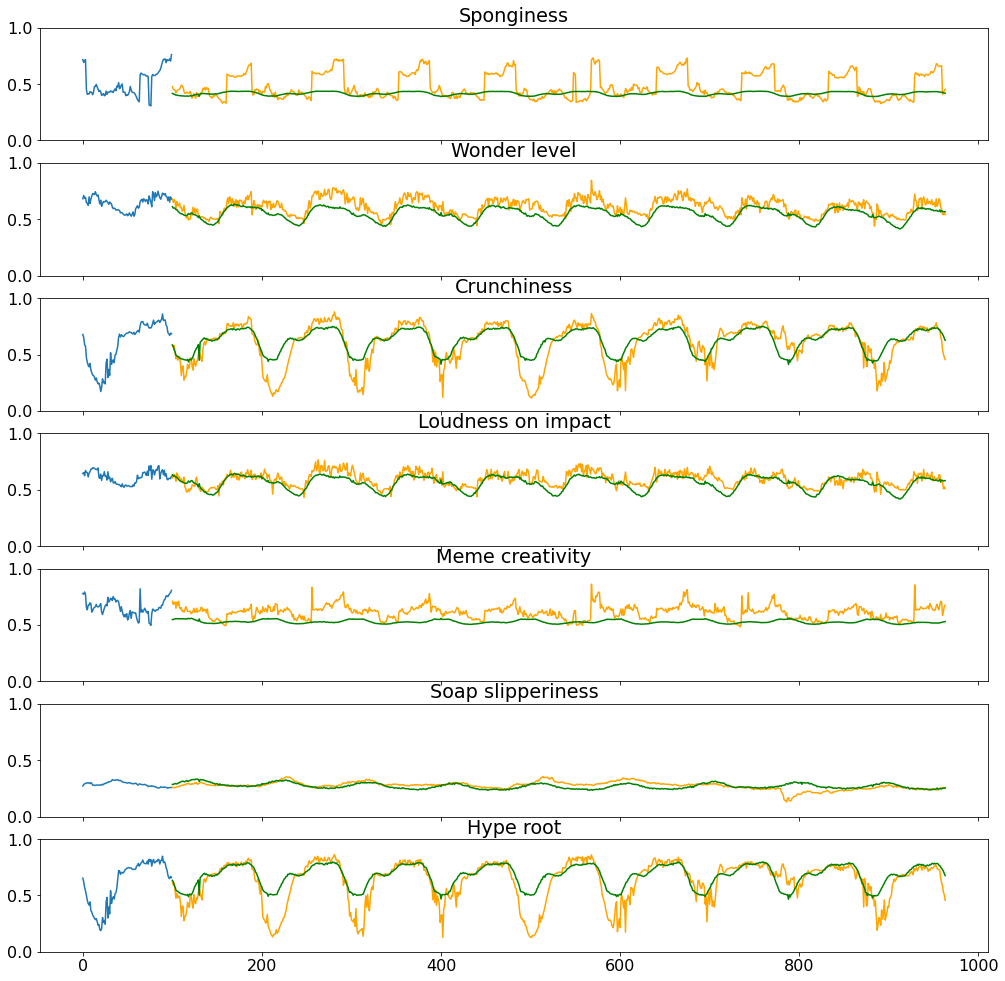

In [18]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

### Predict the **future**

In [19]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [20]:
future_predictions = model.predict(future)

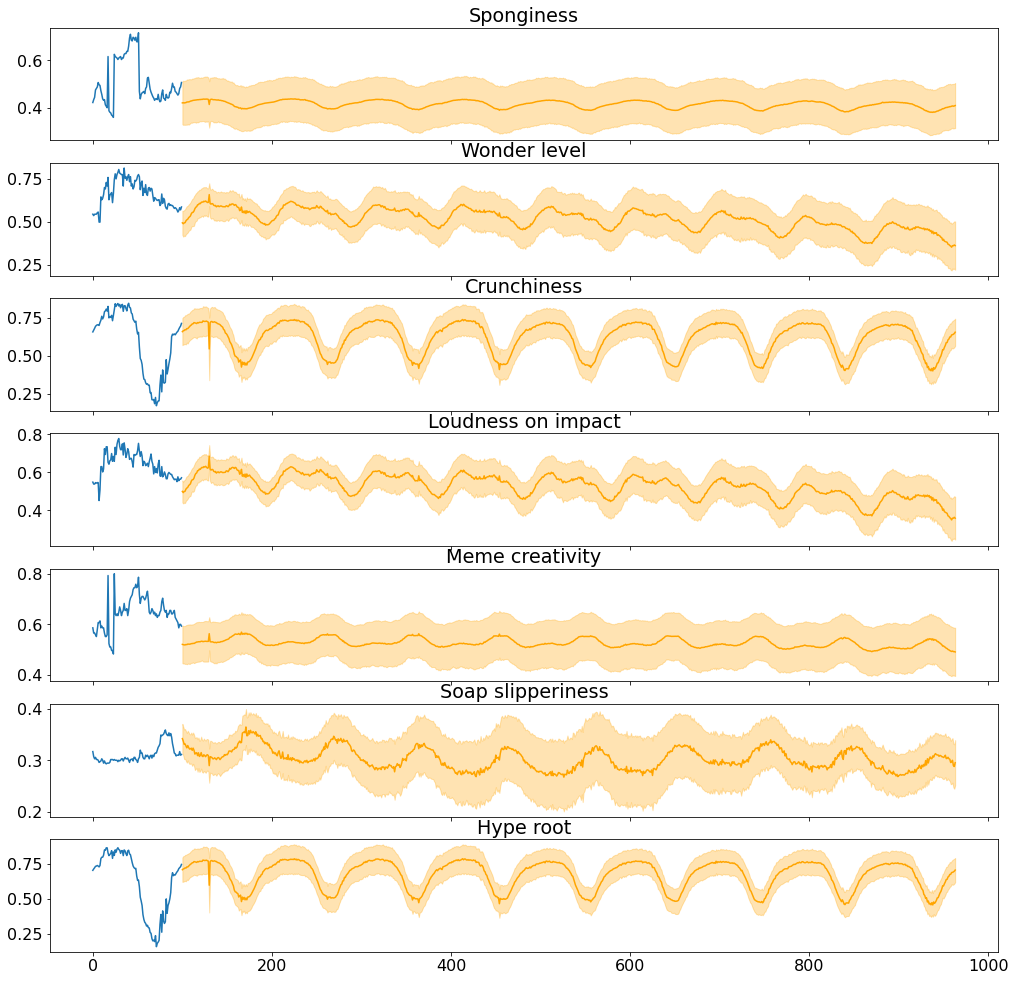

In [21]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

As it is clear, the orange bands do not widen as time increases.